In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

In [16]:
cd C:\Users\MSI-PC\Downloads\SpaGE Datasets\SpaGE Datasets\

C:\Users\MSI-PC\Downloads\SpaGE Datasets\SpaGE Datasets


In [17]:
# Loading Spatial data and setting the output folder
sp_data_folder = './Spatial/'
results_folder = './results/mouse_brain_snrna/'


In [18]:
sample_data = pd.read_csv(sp_data_folder + 'V1_Human_Brain_Section_2/V1_Human_Brain_Section_2_metrics_summary.csv')

In [19]:
def read_and_qc(sample_name, path=sp_data_folder + 'rawdata/'):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

In [20]:
# Merging multiple samples
slides = []
for i in sample_data['Sample ID']:
    slides.append(read_and_qc(i, path=sp_data_folder))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [21]:
adata = slides[0].concatenate(
    slides[1:],
    uns_merge="unique",
    index_unique=None
)

In [22]:
slide = adata

In [23]:
# Loading the Cell2location result (Step2)
r = {'run_name': 'LocationModelLinearDependentWMultiExperiment_1experiments_62clusters_4972locations_9679genes'}

In [24]:
sp_data_file = results_folder +r['run_name']+'/sp.h5ad'

adata_vis = anndata.read(sp_data_file)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [25]:
slide = adata_vis

In [26]:
slide.var['SYMBOL']=slide.var._stat_axis.values.tolist()

In [27]:
slide.var

feature_types  n_cells_by_counts  mean_counts  \
SYMBOL                                                         
MIR1302-2HG  Gene Expression                  0     0.000000   
FAM138A      Gene Expression                  0     0.000000   
OR4F5        Gene Expression                  0     0.000000   
AL627309.1   Gene Expression                 25     0.005028   
AL627309.3   Gene Expression                  0     0.000000   
...                      ...                ...          ...   
AC141272.1   Gene Expression                  0     0.000000   
AC023491.2   Gene Expression                  0     0.000000   
AC007325.1   Gene Expression                  0     0.000000   
AC007325.4   Gene Expression                683     0.152856   
AC007325.2   Gene Expression                242     0.050684   

             log1p_mean_counts  pct_dropout_by_counts  total_counts  \
SYMBOL                                                                
MIR1302-2HG           0.000000             100.000000           0.0   
FAM138A               0.000000             100.000000           0.0   
OR4F5                 0.000000             100.000000           0.0   
AL627309.1            0.005016              99.497184          25.0   
AL627309.3            0.000000             100.000000           0.0   
...                        ...                    ...           ...   
AC141272.1            0.000000             100.000000           0.0   
AC023491.2            0.000000             100.000000           0.0   
AC007325.1            0.000000             100.000000           0.0   
AC007325.4            0.142242              86.263073         760.0   
AC007325.2            0.049441              95.132743         252.0   

             log1p_total_counts     mt       SYMBOL  
SYMBOL                                               
MIR1302-2HG            0.000000  False  MIR1302-2HG  
FAM138A                0.000000  False      FAM138A  
OR4F5                  0.000000  False        OR4F5  
AL627309.1             3.258096  False   AL627309.1  
AL627309.3             0.000000  False   AL627309.3  
...                         ...    ...          ...  
AC141272.1             0.000000  False   AC141272.1  
AC023491.2             0.000000  False   AC023491.2  
AC007325.1             0.000000  False   AC007325.1  
AC007325.4             6.634634  False   AC007325.4  
AC007325.2             5.533390  False   AC007325.2  

[36601 rows x 9 columns]

In [28]:
SYMBOL=slide.var["SYMBOL"]

In [33]:
from scipy.spatial import distance_matrix

In [31]:
from scipy.spatial import distance

In [34]:
metric=adata_vis.obs[["array_row","array_col"]]

In [18]:
from sklearn.metrics.pairwise import euclidean_distances

In [19]:
distance_matrix([distance["array_row"][1],distance["array_col"][1]],[distance["array_row"][2],distance["array_col"][2]]

SyntaxError: unexpected EOF while parsing (<ipython-input-19-693d4910c05b>, line 1)

In [40]:
# Calculate the euclidean distances between each spots based on their coordinates
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
metric=adata_vis.obs[["array_row","array_col"]]
distance.list=[]
for i in range(4972):
    distance.list.append([metric["array_row"][i],metric["array_col"][i]])
Y=euclidean_distances(distance.list)
df = pd.DataFrame(Y)
df.columns=adata_vis.obs_names
df=df.T
df.columns=adata_vis.obs_names
df.to_csv("distance.csv")

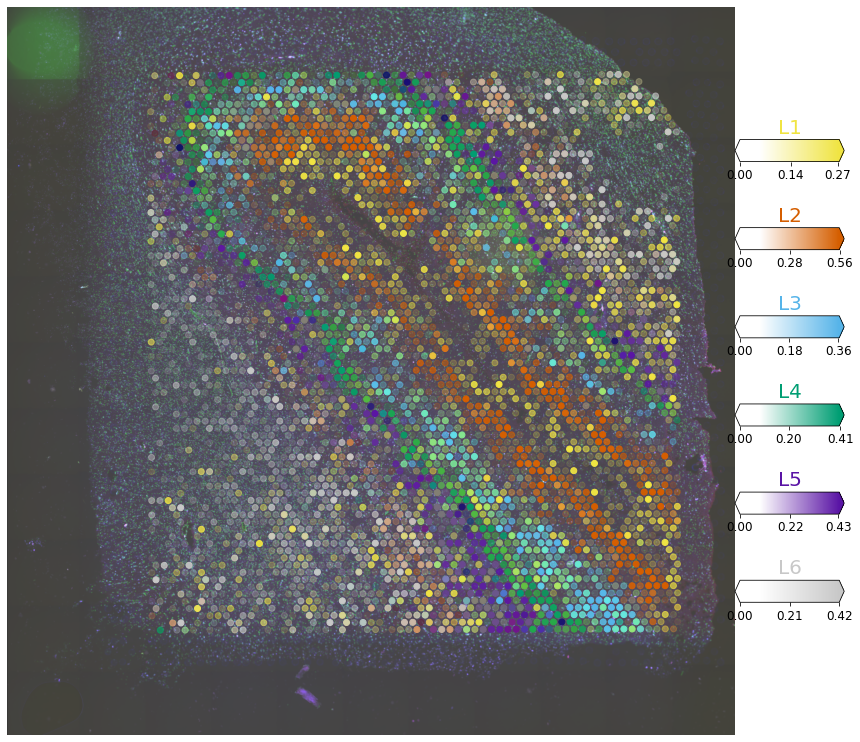

In [35]:
from cell2location.plt.mapping_video import plot_spatial

# select up to 6 clusters
sel_clust = ['L1','L2','L3','L4','L5','L6']
sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(slide.obs[sel_clust_col], labels=sel_clust,
                  coords=slide.obsm['spatial'] \
                          * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'],
                  show_img=True, img_alpha=0.8,
                  style='fast', # fast or dark_background
                  img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=6, colorbar_position='right')

In [36]:
fig.savefig("Layer.jpg")

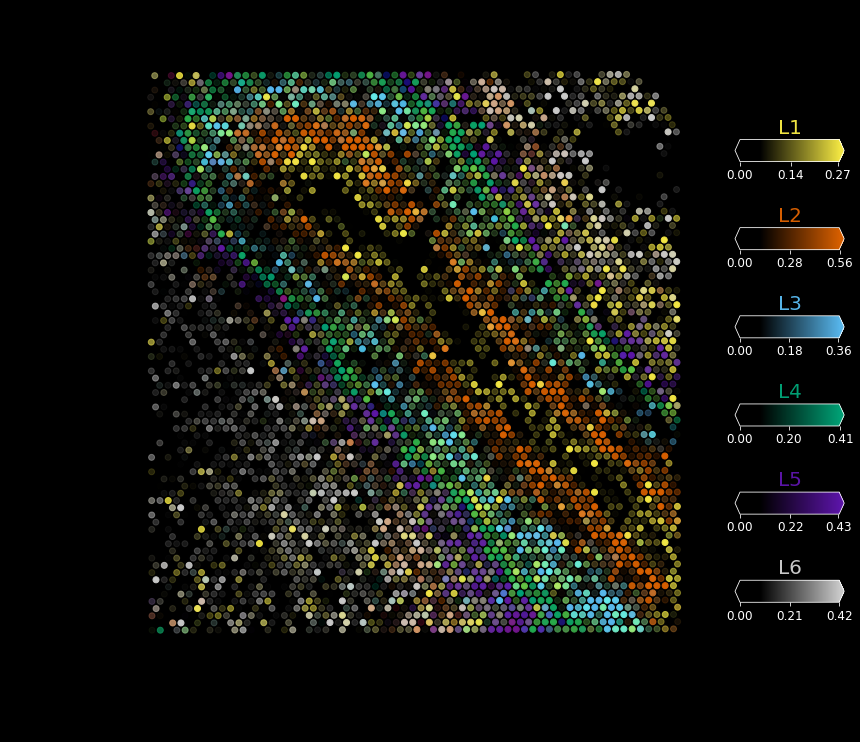

In [20]:
with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(slide.obs[sel_clust_col], labels=sel_clust,
                  coords=slide.obsm['spatial'] \
                          * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'],
                  show_img=True, img_alpha=0,
                  style='dark_background', # fast or dark_background
                  img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=6, colorbar_position='right')

In [38]:
sample_type = 'q05_nUMI_factors'
col_ind = [sample_type in i for i in adata_vis.obs.columns.tolist()]
adata_vis.obsm[sample_type] = adata_vis.obs.loc[:,col_ind].values

# compute KNN using the cell2location output
sc.pp.neighbors(adata_vis, use_rep=sample_type,
                n_neighbors = 20)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"]
adata_vis.obs["region_cluster"] =  adata_vis.obs["region_cluster"].astype("category")

In [39]:


# compute KNN using the cell2location output
sc.pp.neighbors(adata,n_neighbors = 20)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata, resolution=1)

# add region as categorical variable
adata.obs["region_cluster"] = adata.obs["leiden"]
adata.obs["region_cluster"] =  adata.obs["region_cluster"].astype("category")

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [27]:
sc.pp.neighbors(adata,n_neighbors = 20)

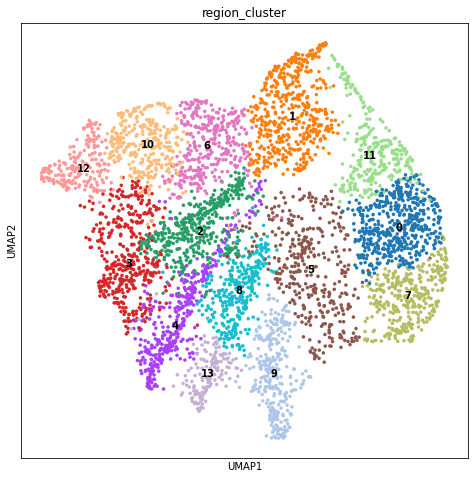

In [40]:
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

with mpl.rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=50,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=10)

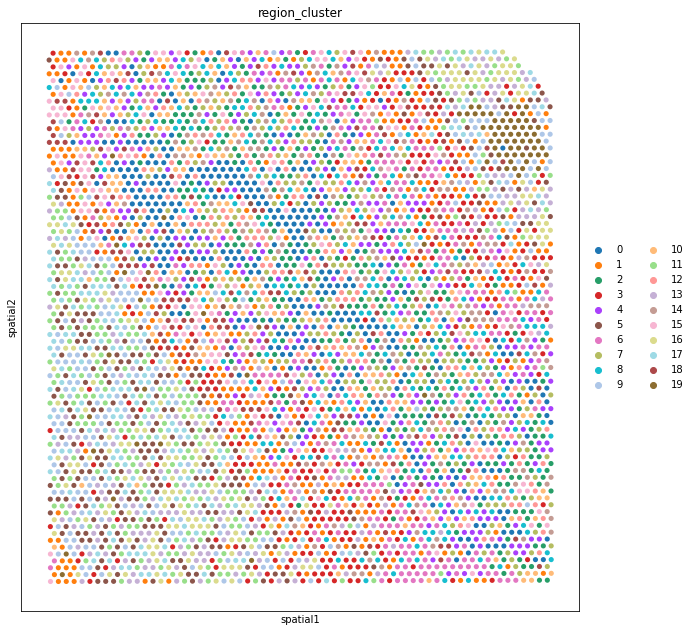

In [35]:
with mpl.rc_context({'figure.figsize': (10, 12)}):
    sc.pl.spatial(adata_vis,
                  color=["region_cluster"], img_key=None
                ,save="1.jpg")

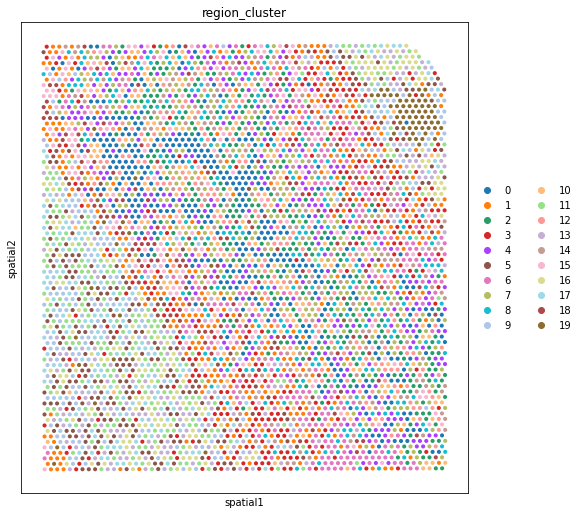

In [37]:
with mpl.rc_context({'figure.figsize': (8, 10)}):
    sc.pl.spatial(adata_vis,
                  color=["region_cluster"], img_key=None
                )

In [31]:
# save maps for each sample separately
sam = np.array(adata_vis.obs['sample'])
for i in np.unique(sam):

    s1 = adata_vis.obs[['region_cluster']]
    s1 = s1.loc[sam == i]
    s1.index = [x[10:] for x in s1.index]
    s1.index.name = 'Barcode'

    s1.to_csv(results_folder +r['run_name']+'/region_cluster29_' + i + '.csv')

In [38]:
# number of cell type combinations - educated guess assuming that most cell types don't co-locate
n_fact = int(20)

# extract cell abundance from cell2location
X_data = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data,
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=adata_vis.obs['sample'],
        init='random', random_state=0,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart')

init_1 - iterations until convergence: 1753
init_2 - iterations until convergence: 4483
init_3 - iterations until convergence: 1198
init_4 - iterations until convergence: 1154
init_5 - iterations until convergence: 1588


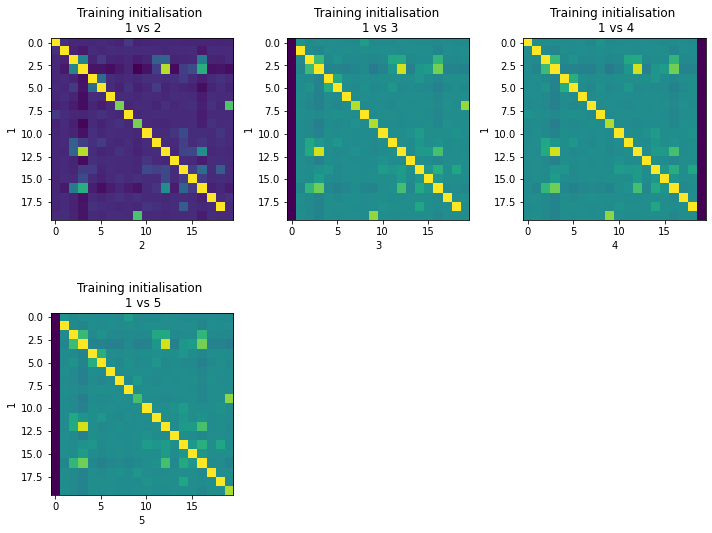

In [39]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

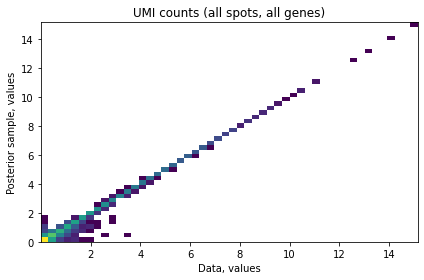

In [40]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

In [41]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions')

top-1      top-2      top-3       top-4  \
mean_cell_type_factorsfact_0    5: 0.41    7: 0.38    11: 0.3    25: 0.18   
mean_cell_type_factorsfact_1   30: 0.83    23: 0.7  57: 0.085    6: 0.063   
mean_cell_type_factorsfact_2   24: 0.71   55: 0.15  48: 0.049   44: 0.045   
mean_cell_type_factorsfact_3   50: 0.76   33: 0.22     6: 0.2   55: 0.047   
mean_cell_type_factorsfact_4    4: 0.79   16: 0.33   44: 0.28    48: 0.22   
mean_cell_type_factorsfact_5    1: 0.89   16: 0.11  61: 0.069   44: 0.063   
mean_cell_type_factorsfact_6   32: 0.85   15: 0.77   42: 0.33    19: 0.26   
mean_cell_type_factorsfact_7     0: 0.0    50: 0.0    39: 0.0      4: 0.0   
mean_cell_type_factorsfact_8   27: 0.88   9: 0.048  16: 0.025   42: 0.024   
mean_cell_type_factorsfact_9   31: 0.83   19: 0.31    23: 0.1   57: 0.073   
mean_cell_type_factorsfact_10   9: 0.68  57: 0.063   42: 0.06   34: 0.049   
mean_cell_type_factorsfact_11  56: 0.88  61: 0.097   9: 0.036   42: 0.016   
mean_cell_type_factorsfact_12  29: 0.94   61: 0.15  56: 0.018   34: 0.015   
mean_cell_type_factorsfact_13  59: 0.95  33: 0.032   6: 0.026  54: 0.0064   
mean_cell_type_factorsfact_14  22: 0.43   17: 0.27   20: 0.22     39: 0.2   
mean_cell_type_factorsfact_15  18: 0.61  44: 0.065  16: 0.055   45: 0.052   
mean_cell_type_factorsfact_16   0: 0.73   49: 0.27   54: 0.21     6: 0.12   
mean_cell_type_factorsfact_17  21: 0.81    14: 0.8   60: 0.78    34: 0.74   
mean_cell_type_factorsfact_18  12: 0.51    8: 0.51    3: 0.51     38: 0.5   
mean_cell_type_factorsfact_19  40: 0.83  19: 0.067  57: 0.032   42: 0.015   

                                   top-5       top-6       top-7       top-8  \
mean_cell_type_factorsfact_0    45: 0.18    16: 0.14    58: 0.12    48: 0.12   
mean_cell_type_factorsfact_1   33: 0.052   54: 0.041   49: 0.031   42: 0.028   
mean_cell_type_factorsfact_2   51: 0.044   16: 0.042    49: 0.03   33: 0.027   
mean_cell_type_factorsfact_3   49: 0.017   57: 0.016  19: 0.0039   16: 0.003   
mean_cell_type_factorsfact_4     51: 0.2    61: 0.14   39: 0.096   45: 0.089   
mean_cell_type_factorsfact_5     4: 0.06   48: 0.051    9: 0.039   51: 0.034   
mean_cell_type_factorsfact_6    57: 0.14     54: 0.1   33: 0.036   49: 0.034   
mean_cell_type_factorsfact_7     40: 0.0     41: 0.0     42: 0.0     43: 0.0   
mean_cell_type_factorsfact_8    6: 0.022   33: 0.022    23: 0.02   34: 0.017   
mean_cell_type_factorsfact_9   61: 0.045   54: 0.034   42: 0.017  40: 0.0079   
mean_cell_type_factorsfact_10  19: 0.045   56: 0.038   54: 0.036   14: 0.031   
mean_cell_type_factorsfact_11  34: 0.015   10: 0.014   28: 0.014   14: 0.014   
mean_cell_type_factorsfact_12  57: 0.012   58: 0.011  36: 0.0068   16: 0.006   
mean_cell_type_factorsfact_13  25: 0.006  49: 0.0016  57: 0.0016  47: 0.0012   
mean_cell_type_factorsfact_14   55: 0.16    35: 0.14    58: 0.12    41: 0.12   
mean_cell_type_factorsfact_15  11: 0.051    7: 0.047   51: 0.046   48: 0.034   
mean_cell_type_factorsfact_16    33: 0.1   57: 0.054   34: 0.044   42: 0.039   
mean_cell_type_factorsfact_17   28: 0.72    35: 0.71     46: 0.7    20: 0.68   
mean_cell_type_factorsfact_18   41: 0.37     2: 0.32    47: 0.31    26: 0.29   
mean_cell_type_factorsfact_19  32: 0.013  26: 0.0059  61: 0.0039  31: 0.0032   

                                    top-9      top-10  
mean_cell_type_factorsfact_0     44: 0.11    47: 0.11  
mean_cell_type_factorsfact_1    15: 0.013   40: 0.011  
mean_cell_type_factorsfact_2    53: 0.019   35: 0.019  
mean_cell_type_factorsfact_3   54: 0.0029  30: 0.0028  
mean_cell_type_factorsfact_4    11: 0.085    7: 0.084  
mean_cell_type_factorsfact_5    43: 0.029   27: 0.027  
mean_cell_type_factorsfact_6     6: 0.033   40: 0.024  
mean_cell_type_factorsfact_7      44: 0.0     45: 0.0  
mean_cell_type_factorsfact_8    26: 0.016   44: 0.013  
mean_cell_type_factorsfact_9    15: 0.006   6: 0.0045  
mean_cell_type_factorsfact_10   10: 0.031     6: 0.03  
mean_cell_type_factorsfact_11    6: 0.013   19: 0.013  
mean_ce

In [42]:
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

In [59]:
slide=adata_vis

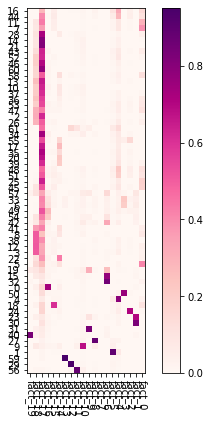

In [43]:
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i)
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[5, 6])

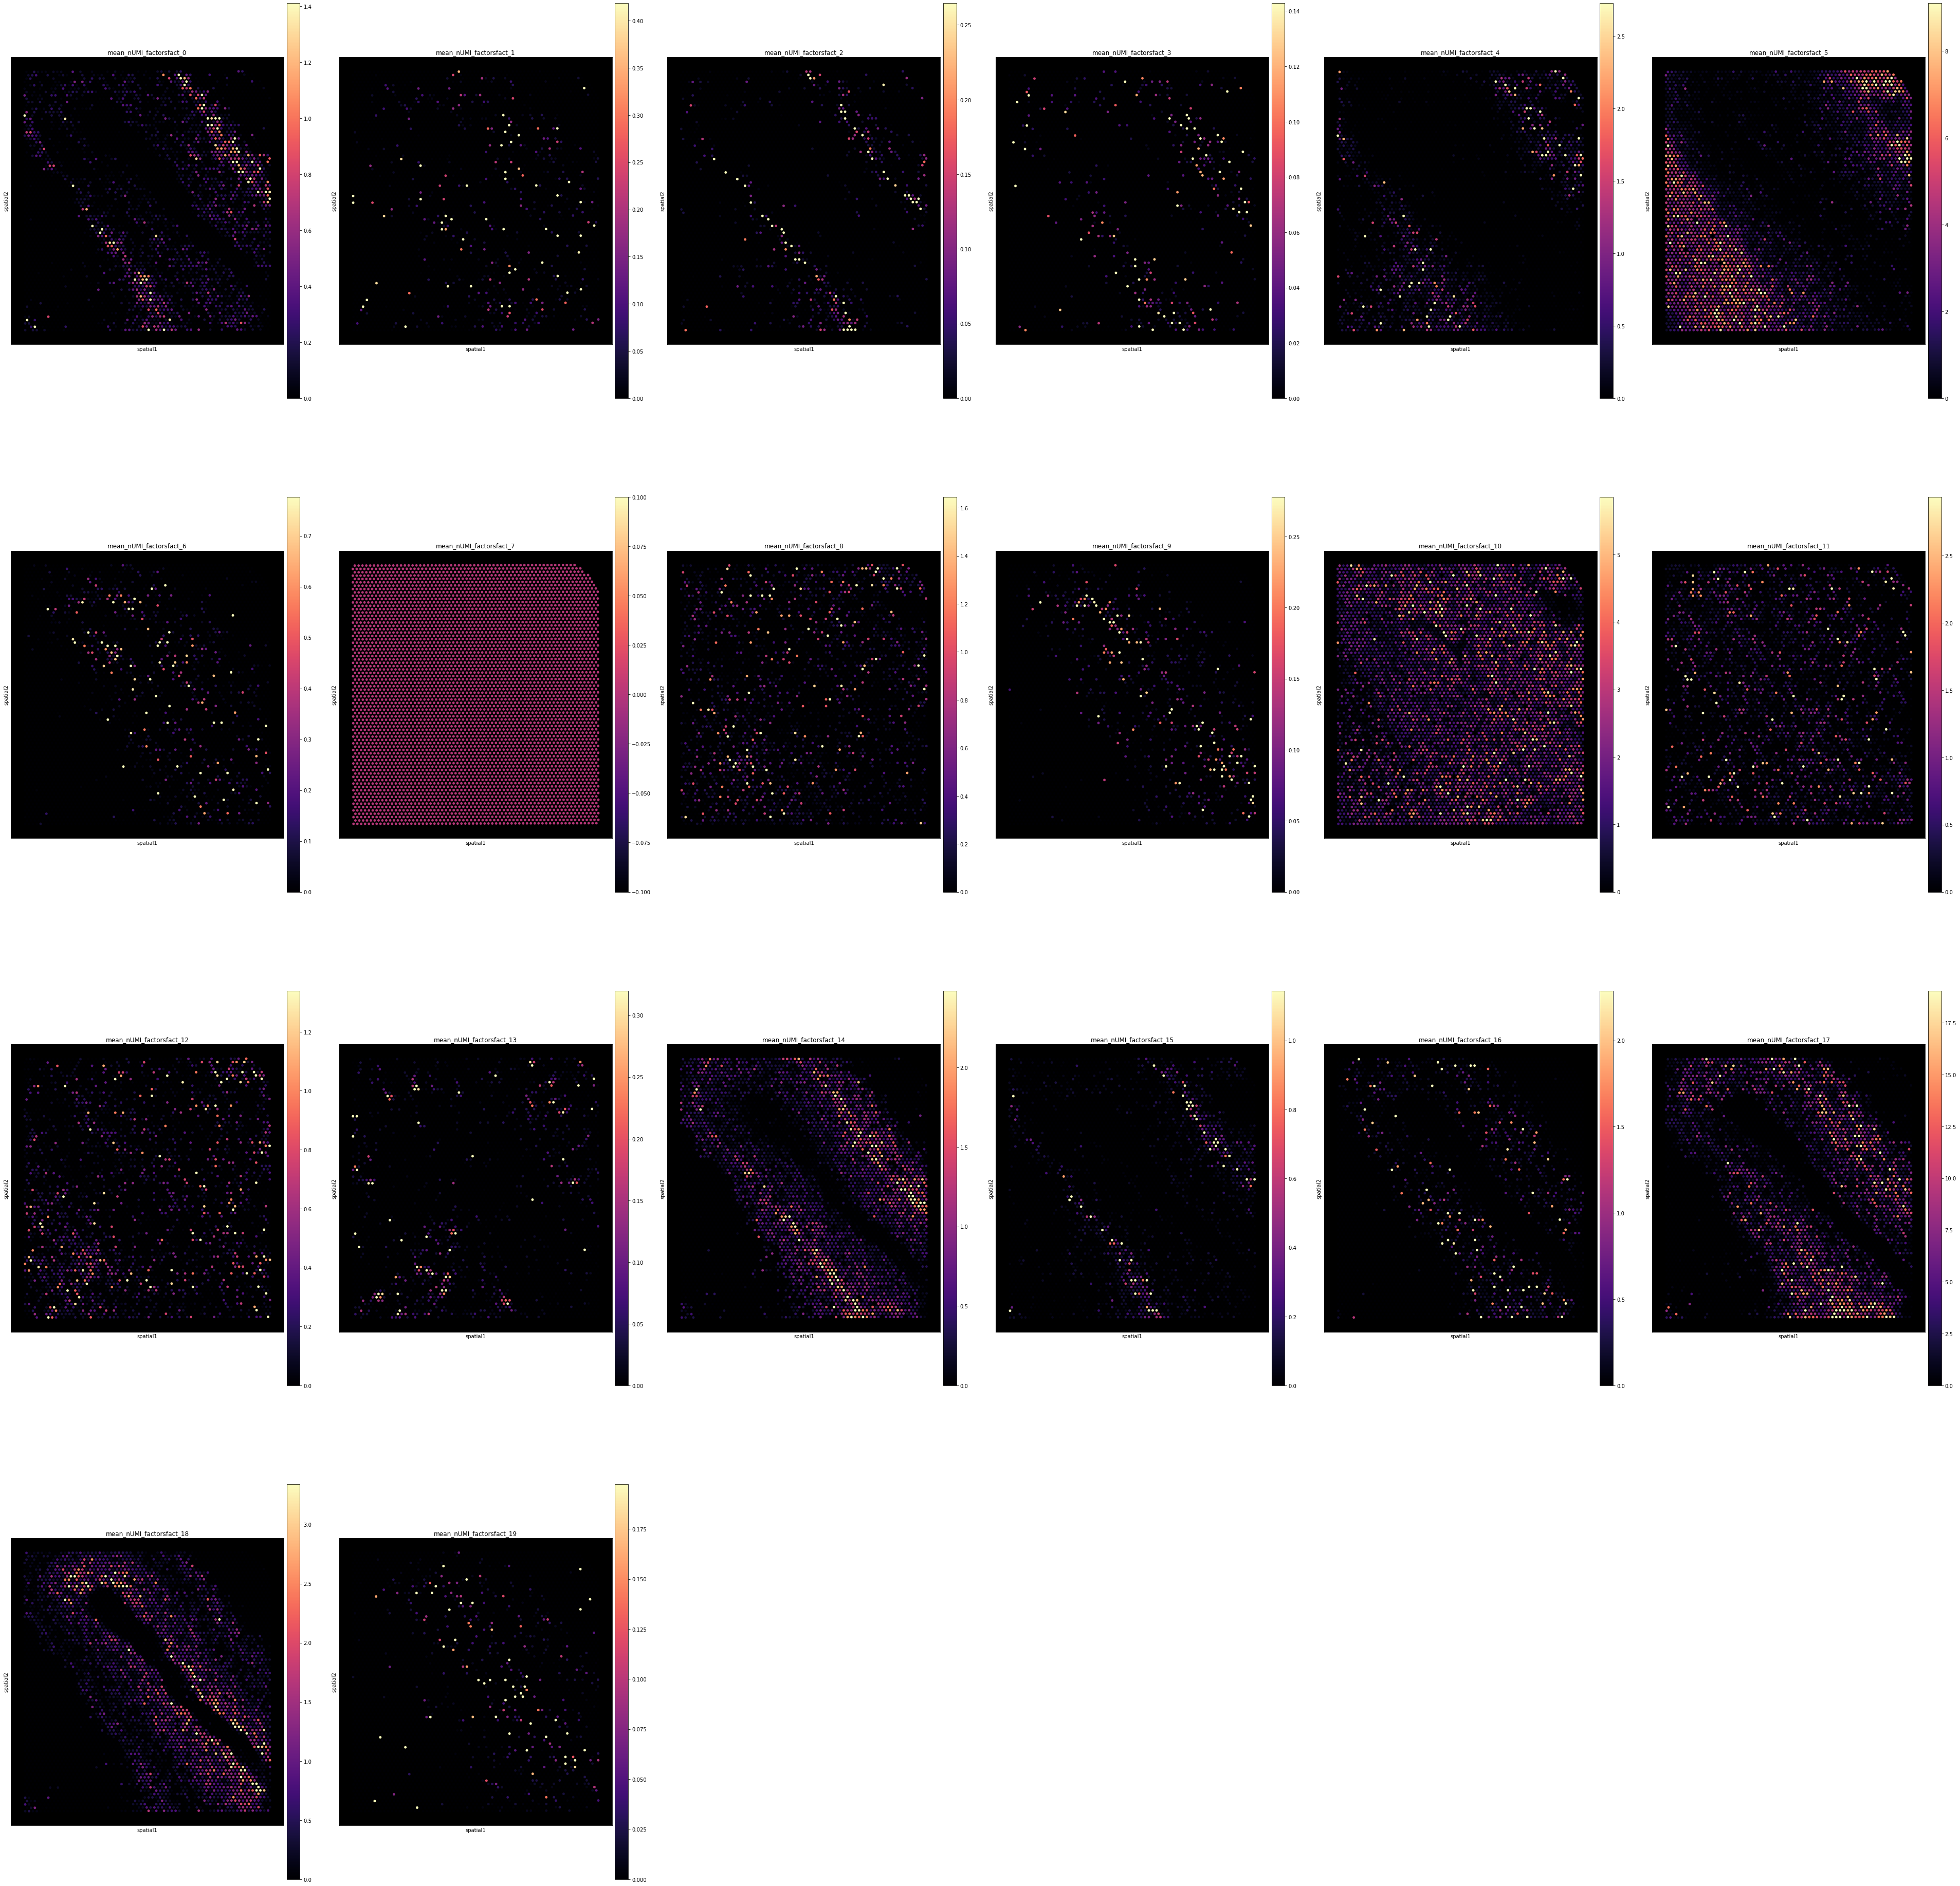

In [44]:
with mpl.rc_context({'figure.figsize': (10, 15), 'axes.facecolor': 'black'}):

    # select one section correctly subsetting histology image data

    sc.pl.spatial(slide,
                  cmap='magma',
                  color=mod_sk.location_factors_df.columns,
                  ncols=6,
                  size=1, img_key='hires',
                  alpha_img=0,
                  vmin=0, vmax='p99.2',save="1.pdf"
                 )

In [87]:
# save co-location models object
def pickle_model(mod, path, file_suffix=''):
    file = path + 'model_' + str(mod.__class__.__name__) + '_' + str(mod.n_fact) + '_' + file_suffix + ".p"
    pickle.dump({'mod': mod, 'fact_names': mod.fact_names}, file = open(file, "wb"))
    print(file)

pickle_model(mod_sk, results_folder +r['run_name'] + '/', file_suffix='')

./results/mouse_brain_snrna/LocationModelLinearDependentWMultiExperiment_1experiments_19clusters_4972locations_20243genes/model_CoLocatedGroupsSklearnNMF_12_.p


In [89]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
                   adata_vis, model_name='CoLocatedGroupsSklearnNMF',
                   verbose=False, return_all=True,

                   train_args={
                    'n_fact': np.arange(10, 40), # IMPORTANT: range of number of factors (10-40 here)
                    'n_iter': 20000, # maximum number of training iterations

                    'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample

                    'mode': 'normal',
                    'n_type': 'restart', 'n_restarts': 5 # number of training restarts
                   },

                   model_kwargs={'init': 'random', 'random_state': 0, 'nmf_kwd_args': {'tol': 0.00001}},

                   posterior_args={},
                   export_args={'path': results_folder + 'std_model/',
                                'run_name_suffix': ''})

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Analysis name: CoLocatedGroupsSklearnNMF_10combinations_4972locations_19factors
Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_4972locations_19factors
Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_4972locations_19factors
Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_13combinations_4972locations_19factors
Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_14combinations_4972locations_19factors
Some error in plotting with scanpy or `cell2location.plt.plot_fa

In [86]:
import pickle

In [90]:
adata_file = results_folder +r['run_name']+'/sp_with_clusters.h5ad'
adata_vis.write(adata_file)
adata_file

'./results/mouse_brain_snrna/LocationModelLinearDependentWMultiExperiment_1experiments_19clusters_4972locations_20243genes/sp_with_clusters.h5ad'